<a href="https://colab.research.google.com/github/guzonghua/saavlabs/blob/main/Lab2/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below is PIDControl Straightline Twiddle.py

In [ ]:
# PIDControl Straightline Twiddle.py from Udacity--------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# Your twiddle function should RETURN the accumulated
# error. Try adjusting the parameters p and dp to make
# this error as small as possible.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
# No cheating!
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt
# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        # res = Robot()
        # res.length = self.length
        # res.steering_noise = self.steering_noise
        # res.distance_noise = self.distance_noise
        # res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run


def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0.0, 1.0, 0.0)
    robot.set_steering_drift(10.0 / 180.0 * np.pi)
    return robot

# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = cte - prev_cte
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    # Don't forget to call `make_robot` before you call `run`!
    p = [0.0, 0.0, 0.0]
    dp = [1.0, 1.0, 1.0]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)

    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err

params, err = twiddle()
print("Final twiddle error = {}".format(err))
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='Twiddle PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')

Below is PIDControl Racetrack.py

In [ ]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------


 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):           
        center1 = [radius, radius] #y,x
        center2 = [radius, 3*radius]
        if self.x > radius and self.x < 3*radius:
            if self.y > radius:
                cte = self.y - (2*radius)
            else:
                cte = -1.0 * self.y
        else:
            if self.x < 2*radius:
                cte = ((self.x - center1[1])**2 + (self.y - center1[0])**2)**0.5 - radius
            else:
                cte = ((self.x - center2[1])**2 + (self.y - center2[0])**2)**0.5 - radius                
        
       
        return cte
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N = 1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        if printflag:
            print (myrobot)
    plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
    plt.show()
    print('**********************************************************************************')
    print('\nFinal parameters: ', params)
    print('\nError: ', err)
    return err / float(N)  
    

radius = 25.0
params = [10.0, 15.0, 0]

 
err = run(params, radius,True)

Below is PIDControl RaceTrack Twiddle.py

**********************************************************************************

Final parameters:  [0.9, 0.0, 0.0]

Error:  350095.93246338423
**********************************************************************************

Final parameters:  [1.9, 0.0, 0.0]

Error:  394200.73485428316
**********************************************************************************

Final parameters:  [-0.10000000000000009, 0.0, 0.0]

Error:  938022.3248256838
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 0.0]

Error:  1155.475642455359
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, 1.0]

Error:  986694.1267252387
**********************************************************************************

Final parameters:  [0.8999999999999999, 1.0, -1.0]

Error:  704971.7344445897
***********************************************************

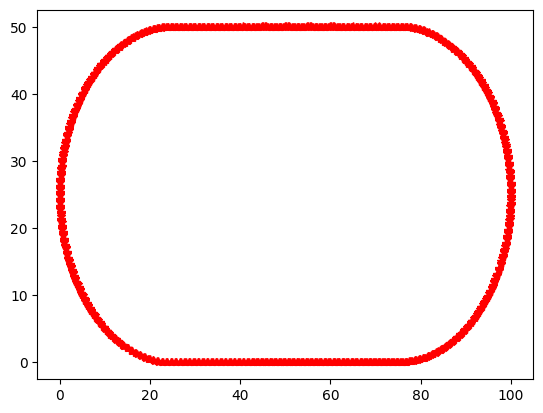

**********************************************************************************

Final parameters:  [10.005223275900004, 20.83639628147047, 2.0690747291060694]

Error:  0.6001070177361296


In [2]:
# --------------
# User Instructions
# 
# Finish the PID in the run function 
#
#
# --------------


 
from math import *
import random
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):#Refer to L6 Control, p 28. 
        center1 = [radius, radius] 
        center2 = [radius, 3*radius]
        if self.x > radius and self.x < 3*radius: # If x lies in the center straight line segment
            if self.y > radius: #If y is above the center line, then compute vertical distance from (x,y) to the top edge of the track
                cte = self.y - (2*radius)
            else: #If y is below the center line, then compute vertical distance from the bottom edge of the track to (x,y)
                cte = -1.0 * self.y
        else:
            if self.x < 2*radius: #If x lies in the left semi-circle segment (self.x <= radius), then compute Euclidian distance from (x,y) to the perimeter of the left semi-circle 
                cte = ((self.x - center1[1])**2 + (self.y - center1[0])**2)**0.5 - radius
            else: #If x lies in the right semi-circle part (self.x >= 3*radius), then compute Euclidian distance from (x,y) to the perimeter of the right semi-circle
                cte = ((self.x - center2[1])**2 + (self.y - center2[0])**2)**0.5 - radius                
        return cte
# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N = 1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        if printflag:
            print (myrobot)
    if printflag:
      plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
      plt.show()
    print('**********************************************************************************')
    print('\nFinal parameters: ', params)
    print('\nError: ', err)
    return err / float(N)  

def twiddle(radius,tol=0.2, p = [0.9, 0.0, 0.0], dp = [1.0, 1.0, 1.0]):  
    p = [0.9, 0.0, 0.0]
    dp = [1.0, 1.0, 1.0]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        # print("Iteration {}, best error = {}".format(it, best_err))
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err


radius = 25.0
#params = [10.0, 15.0, 0]
params,err = twiddle(radius)
err = run(params, radius,True)